# Operator Overloading
`Python 3.10.8`

- How an infix operator method should signal it cannot handle an operand
- Using duck typing or goose typing to deal with operands of various types
- The special behavior of the rich comparison operators (e.g., `==`, `>`, `<=`, etc.)
- The default handling of augmented assignment operators such as `+=`, and how to overload them

Operator overloading allows user-defined objects to interoperate with infix operators such as `+` and `|`, or unary operators like `-` and `~`.  More generally, function invocation `()`, attribute access `.`, and item access/slicing `[]` are also operators in Python, but this chapter covers unary and infix operators.
- We cannot change the meaning of the operators for the built-in types.
- We cannot create new operators, only overload existing ones.
- A few operators can't be overloaded: is, and, or, not (but the bitwise &, |, ~, can).

Special methods implementing unary or infix operators should never change the value of the operands. Expressions with such operators are expected to produce results by creating new objects. Only augmented assignment operators may change the first operand (`self`).

# Unary Operators

In [1]:
from array import array
import reprlib
import math
import numbers
import functools
import operator
import itertools
from collections import abc

In [2]:
class Vector:
    typecode = 'd'

    def __init__(self, components):
        self._components = array(self.typecode, components)

    def __iter__(self):
        return iter(self._components)

    def __repr__(self):
        components = reprlib.repr(self._components)
        components = components[components.find('['):-1]
        return f'Vector({components})'

    def __str__(self):
        return str(tuple(self))

    def __bytes__(self):
        return (bytes([ord(self.typecode)]) +
                bytes(self._components))

    def __eq__(self, other):
        if isinstance(other, Vector):
            return (len(self) == len(other) and
                    all(a == b for a, b in zip(self, other)))
        else:
            return NotImplemented

    def __hash__(self):
        hashes = (hash(x) for x in self)
        return functools.reduce(operator.xor, hashes, 0)

    def __abs__(self):
        return math.hypot(*self)

    def __neg__(self):
        return Vector(-x for x in self)

    def __pos__(self):
        return Vector(self)

    def __bool__(self):
        return bool(abs(self))

    def __len__(self):
        return len(self._components)

    def __getitem__(self, key):
        if isinstance(key, slice):
            cls = type(self)
            return cls(self._components[key])
        index = operator.index(key)
        return self._components[index]

    __match_args__ = ('x', 'y', 'z', 't')

    def __getattr__(self, name):
        cls = type(self)
        try:
            pos = cls.__match_args__.index(name)
        except ValueError:
            pos = -1
        if 0 <= pos < len(self._components):
            return self._components[pos]
        msg = f'{cls.__name__!r} object has no attribute {name!r}'
        raise AttributeError(msg)

    def angle(self, n):
        r = math.hypot(*self[n:])
        a = math.atan2(r, self[n-1])
        if (n == len(self) - 1) and (self[-1] < 0):
            return math.pi * 2 - a
        else:
            return a

    def angles(self):
        return (self.angle(n) for n in range(1, len(self)))

    def __format__(self, fmt_spec=''):
        if fmt_spec.endswith('h'):  # hyperspherical coordinates
            fmt_spec = fmt_spec[:-1]
            coords = itertools.chain([abs(self)],
                                     self.angles())
            outer_fmt = '<{}>'
        else:
            coords = self
            outer_fmt = '({})'
        components = (format(c, fmt_spec) for c in coords)
        return outer_fmt.format(', '.join(components))

    @classmethod
    def frombytes(cls, octets):
        typecode = chr(octets[0])
        memv = memoryview(octets[1:]).cast(typecode)
        return cls(memv)

    def __add__(self, other):
        try:
            pairs = itertools.zip_longest(self, other, fillvalue=0.0)
            return Vector(a + b for a, b in pairs)
        except TypeError:
            return NotImplemented
        
    def __radd__(self, other):
        return self + other

    def __mul__(self, scalar):
        if isinstance(scalar, numbers.Real):
            return Vector(n * scalar for n in self)
        else:
            return NotImplemented

    def __rmul__(self, scalar):
        return self * scalar
    
    def __matmul__(self, other):
        if (isinstance(other, abc.Sized) and
            isinstance(other, abc.Iterable)):
            if len(self) == len(other):
                return sum(a * b for a, b in zip(self, other))
            else:
                raise ValueError('@ requires vectors of equal length.')
        else:
            return NotImplemented

    def __rmatmul__(self, other):
        return self @ other

In [3]:
v = Vector([1, 2, 3])
v

Vector([1.0, 2.0, 3.0])

In [4]:
"""
    def __neg__(self):
        return Vector(-x for x in self)
"""

-v

Vector([-1.0, -2.0, -3.0])

In [5]:
"""
    def __pos__(self):
        return Vector(self)
"""

+v

Vector([1.0, 2.0, 3.0])

In [6]:
"""
    def __add__(self, other):
        try:
            pairs = itertools.zip_longest(self, other, fillvalue=0.0)
            return Vector(a + b for a, b in pairs)
        except TypeError:
            return NotImplemented
"""

v1 = Vector([3, 4, 5])
v2 = Vector([6, 7, 8])
v1 + v2

Vector([9.0, 11.0, 13.0])

In [7]:
v1 + v2 == Vector([3 + 6, 4 + 7, 5 + 8])

True

What happens if we try to add two `Vector` instances of different lengths? We could raise an error, but considering practical applications (such as information retrieval), it’s better to fill out the shortest `Vector` with zeros. This is the result we want:

In [8]:
v1 = Vector([3, 4, 5, 6])
v3 = Vector([1, 2])
v1 + v3

Vector([4.0, 6.0, 5.0, 6.0])

In [9]:
v1 = Vector([3, 4, 5])
v1 + (10, 20, 30)

Vector([13.0, 24.0, 35.0])

1. If `a` has `__add__`, call `a.__add__(b)` and return result unless it’s `NotImplemented`.
2. If `a` doesn't have `__add__`, or calling it returns `NotImplemented`, check if `b` has `__radd__`, then call `b.__radd__(a)` and return result unless it’s `NotImplemented`.
3. If `b` doesn’t have `__radd__`, or calling it returns `NotImplemented`, raise `TypeError` with an unsupported operand types message.

- The `__radd__` method is called the “reflected” or “reversed” version of `__add__`.

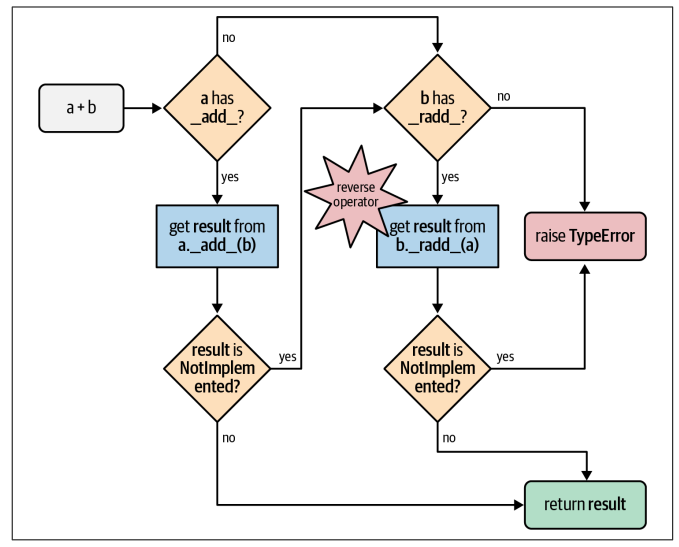

In [10]:
"""
    __radd__ = __add__
"""

"""
    def __radd__(self, other):
        return self + other
"""

v1 = Vector([3, 4, 5])
(10, 20, 30) + v1

Vector([13.0, 24.0, 35.0])

# Infix Operators

### Overloading `*` for Scalar Multiplication

In [11]:
"""
    def __mul__(self, scalar):
        if isinstance(scalar, numbers.Real):
            return Vector(n * scalar for n in self)
        else:
            return NotImplemented
"""

v1 = Vector([1, 2, 3])
v1 * 10

Vector([10.0, 20.0, 30.0])

In [12]:
"""
    def __rmul__(self, scalar):
        return self * scalar
"""

v1 = Vector([1, 2, 3])
11 * v1

Vector([11.0, 22.0, 33.0])

In [13]:
v1 = Vector([1, 2, 3])
v1 * True

Vector([1.0, 2.0, 3.0])

In [14]:
from fractions import Fraction
v1 * Fraction(1, 3)

Vector([0.3333333333333333, 0.6666666666666666, 1.0])

### Using `@` as an Infix Operator
- Implemented in `Python 3.5`

In [15]:
"""
    def __matmul__(self, other):
        if (isinstance(other, abc.Sized) and
            isinstance(other, abc.Iterable)):
            if len(self) == len(other):
                return sum(a * b for a, b in zip(self, other))
            else:
                raise ValueError('@ requires vectors of equal length.')
        else:
            return NotImplemented
"""

va = Vector([1, 2, 3])
vz = Vector([5, 6, 7])
va @ vz

38.0

In [16]:
""""

    def __rmatmul__(self, other):
        return self @ other
"""

[10, 20, 30] @ vz

380.0

In [17]:
va @ 3

TypeError: unsupported operand type(s) for @: 'Vector' and 'int'

# Wrapping-Up Arithmetic Operators
- The techniques we described are applicable to all operators listed in the **Table 16-1**.

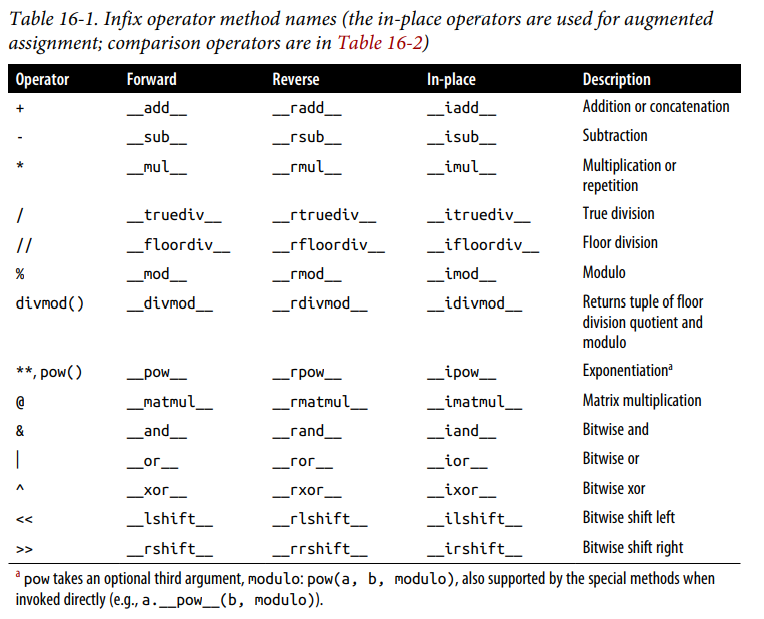

# Rich Comparison Operators
- The same set of methods is used in forward and reverse operator calls. The rules are summarized in **Table 16-2**. For example, in the case of `==`, both the forward and reverse calls invoke `__eq__`, only swapping arguments; and a forward call to `__gt__` is followed by a reverse call to `__lt__` with the arguments swapped.
- In the case of `==` and `!=`, if the reverse method is missing, or returns `NotImplemented`, Python compares the object IDs instead of raising `TypeError`.

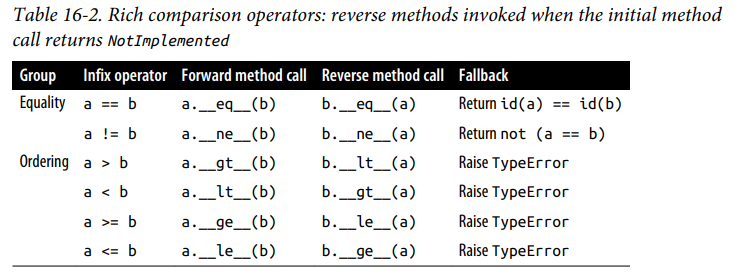

In [18]:
""""
    def __eq__(self, other):
        if isinstance(other, Vector):
            return (len(self) == len(other) and
                    all(a == b for a, b in zip(self, other)))
        else:
            return NotImplemented
"""

va = Vector([1.0, 2.0, 3.0])
vb = Vector(range(1, 4))
va == vb

True

In [19]:
class Vector2d:
    __match_args__ = ('x', 'y')

    typecode = 'd'

    def __init__(self, x, y):
        self.__x = float(x)
        self.__y = float(y)
        
    def __iter__(self):
        return (i for i in (self.__x, self.__y))
    
    def __eq__(self, other):
        return tuple(self) == tuple(other)

In [20]:
vc = Vector([1, 2])
v2d = Vector2d(1, 2)
vc == v2d

True

1. To evaluate `vc == v2d`, Python calls `Vector.__eq__(vc, v2d)`.
2. `Vector.__eq__(vc, v2d)` verifies that `v2d` is not a `Vector` and returns `NotImplemented`.
3. Python gets the `NotImplemented` result, so it tries `Vector2d.__eq__(v2d, vc)`.
4. `Vector2d.__eq__(v2d, vc)` turns both operands into tuples and compares them: the result is `True`.

In [21]:
t3 = (1, 2, 3)
va == t3

False

1. To evaluate `va == t3`, Python calls `Vector.__eq__(va, t3)`.
2. `Vector.__eq__(va, t3)` verifies that t3 is not a `Vector` and returns `NotImplemented`.
3. Python gets the `NotImplemented` result, so it tries `tuple.__eq__(t3, va)`.
4. `tuple.__eq__(t3, va)` has no idea what a `Vector` is, so it returns `NotImplemented`.
5. In the special case of `==`, if the reversed call returns `NotImplemented`, Python compares object IDs as a last resort.

# Augmented Assignment Operators
Our `Vector` class already supports the augmented assignment operators `+=` and `*=`. That’s because augmented assignment works with immutable receivers by creating new instances and rebinding the lefthand variable.

In [22]:
v1 = Vector([1, 2, 3])
v1_alias = v1
id(v1)

2507387730384

In [23]:
v1 += Vector([4, 5, 6])
id(v1)

2507387724192

In [24]:
v1 *= 2

print("v1_alias:", v1_alias, "v1:", v1)
id(v1)

v1_alias: (1.0, 2.0, 3.0) v1: (10.0, 14.0, 18.0)


2507388100640

# Conclusion
### Unary Operators
- `__neg__`, `__pos__`

### Infix Operators
- `__add__`, `__mul__`, `__matmul__`
- Produce results by creating new objects, and should never change their operands.
- Return `NotImplemented` → reverse method (e.g., `__radd__`)

### Duck Typing
- As long as they support the necessary operations.

### Goose Typing
- Good compromise between flexibility and safety.

### Rich Comparison Operators
- `__eq__`, `__ne__` → Never error.

### Augmented Assignment Operators
- `a += b` is evaluated exactly as `a = a + b`. That always creates a new object.
- Mutable → in-place (e.g., ` __iadd__ `)
- Immutable (e.g., ` __iadd__ `)

# Supplement

### When x and +x Are Not Equal

##### Case 1: decimal

In [25]:
import decimal

ctx = decimal.getcontext()
ctx

Context(prec=28, rounding=ROUND_HALF_EVEN, Emin=-999999, Emax=999999, capitals=1, clamp=0, flags=[], traps=[InvalidOperation, DivisionByZero, Overflow])

In [26]:
ctx.prec = 40
one_third = decimal.Decimal('1') / decimal.Decimal('3')
one_third

Decimal('0.3333333333333333333333333333333333333333')

In [27]:
one_third == +one_third

True

In [28]:
ctx.prec = 28
one_third == +one_third

False

In [29]:
+one_third

Decimal('0.3333333333333333333333333333')

`+one_third` produces a new Decimal instance from the value of `one_third`, but using the precision of the current arithmetic context.

##### Case 2: Counter

In [30]:
import collections

ct = collections.Counter('abracadabra')
ct

Counter({'a': 5, 'b': 2, 'r': 2, 'c': 1, 'd': 1})

In [31]:
ct['r'] = -3
ct['d'] = 0
ct

Counter({'a': 5, 'b': 2, 'r': -3, 'c': 1, 'd': 0})

In [32]:
+ct

Counter({'a': 5, 'b': 2, 'c': 1})

For practical reasons, `Counter` addition discards from the result any item with a negative or zero count. And the prefix `+` is a shortcut for adding an empty `Counter`, therefore it produces a new `Counter`, preserving only the tallies that are greater than zero.

# Reference
- [Fluent Python Chpater 10 Design Patterns with First-Class Functions](https://bibis.ir/science-books/programming/python/2022/Fluent%20Python%20Clear,%20Concise,%20and%20Effective%20Programming,%202nd%20Edition%20by%20Luciano%20Ramalho_bibis.ir.pdf), Page (591 - 619) / 1011
- [Fluent Python second edition example code](https://github.com/fluentpython/example-code-2e/tree/master/16-op-overloading)